# Installing Neural Forecast

In [1]:
# To install Neuralforecast refer to https://nixtlaverse.nixtla.io/neuralforecast/examples/installation.html

# Importing Neural Forecast

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.utils import AirPassengersDF
from neuralforecast.losses.pytorch import MAE, MSE, RMSE, MAPE, SMAPE, MASE

# Uploading and splitting the data

In [17]:
# Split data and declare panel dataset
Y_df = AirPassengersDF
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test
Y_df.tail()

,unique_id,ds,y
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0
143,1.0,1960-12-31,432.0


# Setting up the model

In [2]:
#!pip install mlflow
# MLflow setup
# Run this command with environment activated: mlflow ui --port xxxx (e.g. 5000, 5001, 5002)
# Copy and paste url from command line to web browser

In [ ]:
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [18]:
import mlflow
import mlflow.data
from mlflow.data.pandas_dataset import PandasDataset
from mlflow.client import MlflowClient

mlflow.pytorch.autolog()

with mlflow.start_run() as run:

    dataset: PandasDataset = mlflow.data.from_pandas(Y_df, source="AirPassengersDF")

    # Log the dataset to the MLflow Run. Specify the "training" context to indicate that the
    # dataset is used for model training
    mlflow.log_input(dataset, context="training")
    horizon = len(Y_test_df)
    mlflow.log_param("model_type", "NBEATSx_1h_300epochs")
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("scaler_type", "robust")
    mlflow.log_param("input_size", 1 * horizon)
    mlflow.log_param("accelerator", "cuda")
    mlflow.log_param("activation", "ReLU")
                     
    # Fit and predict with NBEATSx model
   
    

    models = [NBEATSx(input_size=1 * horizon, h=horizon, max_steps=300,  
                loss=MAE(),
                valid_loss=MAE(), 
                 accelerator='cuda', 
                 activation='ReLU',
                scaler_type = 'robust',
                  random_seed = 42,
                ),
                ]


    nf = NeuralForecast(models=models, freq='M')           
    train = nf.fit(df=Y_train_df)                                  
    forecast = nf.predict(futr_df=Y_test_df)
    Y_hat_df = forecast

mlflow.metrics.mae()

# Save conda environment used to run the model
mlflow.pytorch.get_default_conda_env()

# Save pip requirements
mlflow.pytorch.get_default_pip_requirements()

# Save the neural forecast model
nf.save(path='./checkpoints/test_run_1/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

# Registering model
model_uri = f"runs:/{run.info.run_id}/neuralforecast-model"
mlflow.register_model(model_uri=model_uri, name="Neuralforecast_model")

Global seed set to 42


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2024/02/18 00:43:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Predicting: 0it [00:00, ?it/s]

Registered model 'Neuralforecast_model' already exists. Creating a new version of this model...
Created version '2' of model 'Neuralforecast_model'.


# Forecast the future

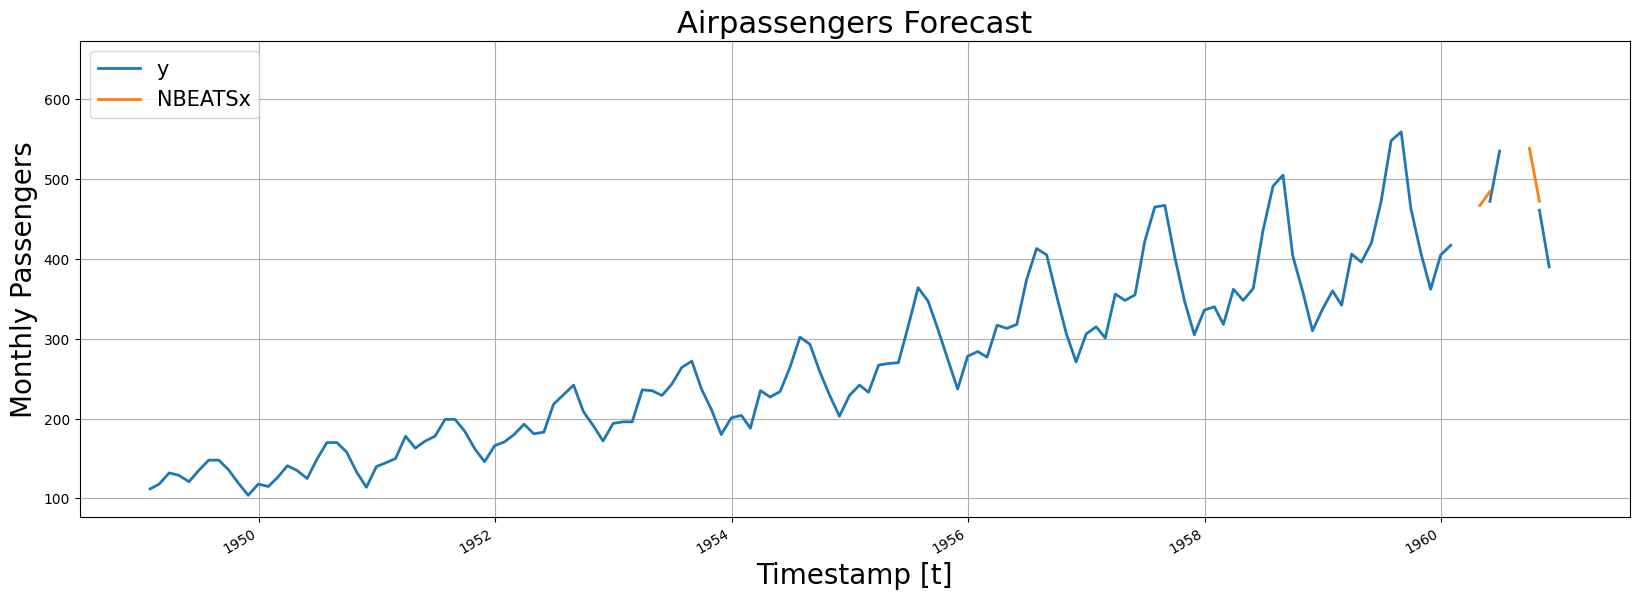

In [19]:
# Plot predictions

plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df[['y', 'NBEATSx']].plot(ax=ax, linewidth=2)                          

ax.set_title('Airpassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()